## Groupe_11
### Project 6: Climate-Smart Agriculture Recommender 

**Problem Statement**  
Farmers need guidance on crop selection as climate patterns shift. Build a recommendation system for climate-appropriate crops.

### Data Sources:

- FAO Global Agro-Ecological Zones: Data portal Climate.gov
- historical weather data: NOAA data portal
- Market price data from regional commodity exchanges

### Deliverables:

1. Crop suitability maps under current and projected climate 
2. Recommendation engine for crop selection
3. Profit optimization model including climate risk
4. Farmer decision-support tool prototype Technical report 

### Technical Requirements:

- Implement collaborative filtering for recommendations
- Use Random Forest for suitability classification
- Monte Carlo simulation for risk analysis
- Create interactive Streamlit app


## 1- Introduction

The present project aims to develop a recommender system that helps farmers make better decisions in the face of climate change. The system should suggest climate-smart agriculture (CSA) practices based on factors such as:
- soil (type, pH, fertility, water retention, texture) 
- crop (type, crop types, planting/harvest times)
- local weather patterns (Rain, Temperature, drought patterns, seasonal changes)
- water availability (irrigation system)
- farming goals (yield or sustainability)

This tool will promote sustainable agriculture by recommending specific actions or technologies that:
- increase productivity
- help adapt to climate change
- reduce greenhouse gas emissions

In [1]:
# modules importation
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor



## 2- Data collection

In [2]:
# load data collected
#Data collected on https://www.fao.org/faostat/en/#data
crop_data_quantity = pd.read_csv("data/Crop_data_quantity.csv")
crop_data_USD = pd.read_csv("data/Crop_data_USD.csv")
temperature_change = pd.read_csv("data/temperature_change.csv")

# Data collected on https://open-meteo.com/en/docs/historical-weather-api?start_date=1970-01-01&latitude=-1.2833&longitude=36.8167&daily=temperature_2m_mean,temperature_2m_max,temperature_2m_min,rain_sum,weather_code&timezone=Africa%2FCairo&hourly=&end_date=1970-01-01
meteo_data = pd.read_csv("data/meteo_data.csv")

## 3- Data cleaning

### 3-1 Cleaning crop_data_quatity

In [3]:
# Crop_data_quantity cleaning

crop_data_quantity.head(3)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,404,Kenya,5312,Area harvested,1701.0,"Beans, dry",1961,1961,ha,115000.0,E,Estimated value,NaN
1,QCL,Crops and livestock products,404,Kenya,5412,Yield,1701.0,"Beans, dry",1961,1961,kg/ha,478.3,E,Estimated value,NaN
2,QCL,Crops and livestock products,404,Kenya,5510,Production,1701.0,"Beans, dry",1961,1961,t,55000.0,E,Estimated value,NaN


In [4]:
# Unnecessary column removal

crop_data_quantity = crop_data_quantity.drop(columns=["Domain Code","Area Code (M49)","Area", "Domain", "Note", "Year Code", "Element Code","Item Code (CPC)", "Flag", "Flag Description"])

In [5]:
crop_data_quantity.head(2)

,Element,Item,Year,Unit,Value
0,Area harvested,"Beans, dry",1961,ha,115000.0
1,Yield,"Beans, dry",1961,kg/ha,478.3


In [6]:
#We are removing the Yiel lines besause we dont need it

crop_data_quantity = crop_data_quantity[crop_data_quantity["Element"].isin(["Area harvested","Production"])]

In [7]:
# We are removing the soya beans and yams data because they have too much missing value

crop_data_quantity = crop_data_quantity[~crop_data_quantity["Item"].isin(["Soya beans","Yams"])]
crop_data_quantity["Item"].unique()

array(['Beans, dry', 'Cassava, fresh', 'Maize (corn)', 'Millet',
       'Potatoes', 'Rice', 'Sorghum', 'Sweet potatoes', 'Tomatoes',
       'Wheat'], dtype=object)

In [8]:
# Verification of the non value sum

crop_data_quantity.isnull().sum()

Element    0
Item       0
Year       0
Unit       0
Value      0
dtype: int64

In [9]:
# Extraction of the area values to put in column
area = crop_data_quantity[crop_data_quantity["Element"]=="Area harvested"]
area = area.rename(columns={"Value":"Area(ha)"})
area = area.drop(columns=["Element","Unit"])
area.reset_index(inplace=True, drop=True)

In [10]:
area["Year"].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [11]:
area.shape

(630, 3)

In [12]:
production = crop_data_quantity[crop_data_quantity["Element"]=="Production"]
production = production.rename(columns={"Value":"Production(T)"})
production = production.drop(columns=["Element","Unit", "Item", "Year"])
production.reset_index(inplace=True, drop=True)

In [13]:
production.isnull().sum()

Production(T)    0
dtype: int64

In [14]:
production.shape

(630, 1)

In [15]:
# concatenation of Area harvested data with the production data

crop_quantity_clean = pd.concat([area,production], axis=1)
crop_quantity_clean.sample(3)

,Item,Year,Area(ha),Production(T)
466,Sweet potatoes,1986,51000.0,505312.00
421,Sorghum,2004,123155.0,69508.00
122,"Cassava, fresh",2020,61754.0,886722.31


### 3-2 Cleaning crop_data_USD

In [16]:
crop_data_USD.head(2)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QV,Value of Agricultural Production,404,Kenya,58,Gross Production Value (constant 2014-2016 tho...,1701.0,"Beans, dry",1961,1961,1000 USD,43914,E,Estimated value
1,QV,Value of Agricultural Production,404,Kenya,58,Gross Production Value (constant 2014-2016 tho...,1701.0,"Beans, dry",1962,1962,1000 USD,43914,E,Estimated value


In [17]:
# Unecessary column removal, "Domain Code","Area Code (M49)","Area", "Domain", "Note", "Year Code"

crop_data_USD = crop_data_USD.drop(columns=["Domain Code","Unit","Element","Area Code (M49)","Area", "Domain", "Year Code", "Element Code","Item Code (CPC)", "Flag", "Flag Description"])

In [18]:
# Column renaming

crop_data_USD = crop_data_USD.rename(columns={"Value":"Amount(1000USD)"})
crop_data_USD.head(2)

,Item,Year,Amount(1000USD)
0,"Beans, dry",1961,43914
1,"Beans, dry",1962,43914


In [19]:
crop_data_USD = crop_data_USD.drop(columns=["Item","Year"])

In [20]:
# Concatenation of crop quantity data with the crop value in USD data

crop_data = pd.concat([crop_quantity_clean,crop_data_USD], axis=1)
crop_data.head(2)

,Item,Year,Area(ha),Production(T),Amount(1000USD)
0,"Beans, dry",1961,115000.0,55000.0,43914
1,"Beans, dry",1962,115000.0,55000.0,43914


### 3-3 Cleaning temperature change

In [21]:
temperature_change.head(2)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Months Code,Months,Year Code,Year,Unit,Value,Flag,Flag Description
0,ET,Temperature change on land,404,Kenya,7271,Temperature change,7001,January,1961,1961,°c,0.514,E,Estimated value
1,ET,Temperature change on land,404,Kenya,7271,Temperature change,7001,January,1962,1962,°c,-0.913,E,Estimated value


In [22]:
temperature_change[temperature_change["Year"]==1961].shape

(26, 14)

In [23]:
# Unecessary column removal, "Domain Code","Area Code (M49)","Area", "Domain", "Note", "Year Code"

temperature_change = temperature_change.drop(columns=["Domain Code","Domain", "Area Code (M49)", "Area", "Element Code", "Element", "Months Code", "Year Code", "Unit", "Flag", "Flag Description"])

In [24]:
temperature_change["Months"].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December',
       'Meteorological year'], dtype=object)

In [25]:
# Extraction of the meteorological annual temperature channge data from 1961 to 2023

temperature_change = temperature_change[temperature_change["Months"]=="Meteorological year"]
temperature_change = temperature_change.iloc[0:63]
temperature_change.reset_index(drop=True, inplace=True)

In [26]:
temperature_change = temperature_change.drop(columns = ["Months", "Year"])

In [27]:
# Multilication of the number of lines to meet the 10 crops selected

temp_repeated = pd.DataFrame(np.tile(temperature_change.values, (10, 1)), columns=temperature_change.columns)
temp_repeated.shape

(630, 1)

In [28]:
# concatenation of the crop quantity data, USD data and temperature change data
crop_data = pd.concat([crop_data, temp_repeated], axis=1)
crop_data.head(2)

,Item,Year,Area(ha),Production(T),Amount(1000USD),Value
0,"Beans, dry",1961,115000.0,55000.0,43914,0.290
1,"Beans, dry",1962,115000.0,55000.0,43914,-0.234


In [29]:
# Renaming the temperature column
crop_data = crop_data.rename(columns={"Value":"Temp_change(C)"})
crop_data.head(2)

,Item,Year,Area(ha),Production(T),Amount(1000USD),Temp_change(C)
0,"Beans, dry",1961,115000.0,55000.0,43914,0.290
1,"Beans, dry",1962,115000.0,55000.0,43914,-0.234


### 3-4 Cleaning meteo_data

In [30]:
meteo_data.head()

,latitude,longitude,elevation,utc_offset_seconds,timezone,timezone_abbreviation
0,-1.3005272,36.824646,1677.0,10800,Africa/Cairo,GMT+3
1,time,temperature_2m_mean (°C),temperature_2m_max (°C),temperature_2m_min (°C),rain_sum (mm),weather_code (wmo code)
2,2000-01-01,18.8,24.9,13.9,0.20,51
3,2000-01-02,18.7,23.9,14.2,0.00,3
4,2000-01-03,18.7,24.2,15.1,0.00,3


In [31]:
# Unnecessary columns removal

meteo_data = meteo_data.drop(columns=["elevation","utc_offset_seconds","timezone_abbreviation"])
meteo_data.head(2)

,latitude,longitude,timezone
0,-1.3005272,36.824646,Africa/Cairo
1,time,temperature_2m_mean (°C),rain_sum (mm)


In [32]:
# Columns renaming

meteo_data = meteo_data.rename(columns={"latitude":"date","longitude":"temperature(C)", "timezone":"rain(mm)"})

In [33]:
# Unecessary rows removal

meteo_data = meteo_data.drop([0, 1]).reset_index(drop=True)
meteo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9340 entries, 0 to 9339
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            9340 non-null   object
 1   temperature(C)  9340 non-null   object
 2   rain(mm)        9340 non-null   object
dtypes: object(3)
memory usage: 219.0+ KB


In [34]:
# conversion of the type of the data, temperature and rain data columns because they are initially object type

meteo_data["date"]=pd.to_datetime(meteo_data["date"])
meteo_data["temperature(C)"] = meteo_data["temperature(C)"].astype(float)
meteo_data["rain(mm)"] = meteo_data["rain(mm)"].astype(float)

In [35]:
meteo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9340 entries, 0 to 9339
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            9340 non-null   datetime64[ns]
 1   temperature(C)  9340 non-null   float64       
 2   rain(mm)        9340 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 219.0 KB


In [36]:
# Extraction of the year in the year column

meteo_data['year'] = meteo_data['date'].dt.year

In [37]:
# Grouping the data to have the mean of temperature per year

mean_temp = meteo_data.groupby('year')['temperature(C)'].mean().reset_index()
mean_temp.head(2)

,year,temperature(C)
0,2000,18.778689
1,2001,18.400548


In [38]:
mean_temp = mean_temp.drop(columns="year")

In [39]:
# Grouping data to have the sum of all the rain per year

sum_rain = meteo_data.groupby('year')['rain(mm)'].sum().reset_index()
sum_rain.head(2)

,year,rain(mm)
0,2000,236.2
1,2001,630.8


In [40]:
# concatenation of the temperature data and rain data in meteo data

meteo = pd.concat([sum_rain,mean_temp], axis=1)
meteo.head(2)

,year,rain(mm),temperature(C)
0,2000,236.2,18.778689
1,2001,630.8,18.400548


In [41]:
# crop data combination with meteo data
# extrapolation of temperature data because the meteo data is from 2000 to 2025 and the crop data is from 1961 to 2024

In [42]:
# filter the data from 2000 to 2023

meteo = meteo[meteo['year'].between(2000, 2023)]

In [43]:
# Means calculation of data from 2000 to 2023

temperature_mean = meteo["temperature(C)"].mean()
rain_mean = meteo["rain(mm)"].mean()

In [44]:
# Creating a dataframe of missing years
missing_year = pd.DataFrame({"year": range(1961,2000)})

#filling the data with the means calculated
missing_year["rain(mm)"] = rain_mean
missing_year ["temperature(C)"] = temperature_mean

In [45]:
#combining the missing years with meteo data

meteo_extended = pd.concat([missing_year, meteo], ignore_index=True)
meteo_extended.head(3)

,year,rain(mm),temperature(C)
0,1961,675.058333,18.790179
1,1962,675.058333,18.790179
2,1963,675.058333,18.790179


In [46]:
# multiplication of the number of line to fit all the 10 crops

meteo_extended = pd.DataFrame(np.tile(meteo_extended,(10,1)), columns = meteo_extended.columns)

In [47]:
#Removing the year column to ease the concatenation with crop data

meteo_extended = meteo_extended.drop(columns = "year")

In [48]:
# Concatenation with the crop data

clean_data_ex = pd.concat([crop_data, meteo_extended], axis=1)

In [49]:
# Data containing the extrapolated data
clean_data_ex.head(2)

,Item,Year,Area(ha),Production(T),Amount(1000USD),Temp_change(C),rain(mm),temperature(C)
0,"Beans, dry",1961,115000.0,55000.0,43914,0.290,675.058333,18.790179
1,"Beans, dry",1962,115000.0,55000.0,43914,-0.234,675.058333,18.790179


In [50]:
# Data that contain real data measured from 2000 to 2023

clean_data = clean_data_ex[clean_data_ex["Year"]>=2000]

In [51]:
clean_data.reset_index(drop=True, inplace=True)

In [52]:
clean_data.head(2)

,Item,Year,Area(ha),Production(T),Amount(1000USD),Temp_change(C),rain(mm),temperature(C)
0,"Beans, dry",2000,770797.0,331426.0,264621,0.553,236.2,18.778689
1,"Beans, dry",2001,870357.0,331426.0,264621,0.603,630.8,18.400548


In [53]:
# Data cleaning ended
# We have two types of datasets
# 1- clean_data containing the real values measured for both crop and meteo data covering 2000 to 2023
# 2- clean_data_ex containing the data of the meteo extrapolated covering 1961 to 2023

# The idea is to do an analysis of both datasets and see the difference in the results

In [54]:
# Saving the clean data to the memory
clean_data.to_csv("data/Clean_data_for_analysis.csv", index=False)
clean_data_ex.to_csv("data/Clean_data_extrapolated_for_analysis.csv", index=False) 

## 4- Data anlysis

In [55]:
clean_data.head(2)

,Item,Year,Area(ha),Production(T),Amount(1000USD),Temp_change(C),rain(mm),temperature(C)
0,"Beans, dry",2000,770797.0,331426.0,264621,0.553,236.2,18.778689
1,"Beans, dry",2001,870357.0,331426.0,264621,0.603,630.8,18.400548


In [56]:
# Yield calculation and puting in new column

clean_data["Yield(t/ha)"] = clean_data["Production(T)"] / clean_data["Area(ha)"]
#clean_data["unit_price"] = (clean_data["Amount(1000USD)"]*1000)/clean_data["Production(T)"]

/tmp/ipykernel_24879/375036898.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data["Yield(t/ha)"] = clean_data["Production(T)"] / clean_data["Area(ha)"]


In [57]:
clean_data.head(50)

,Item,Year,Area(ha),Production(T),Amount(1000USD),Temp_change(C),rain(mm),temperature(C),Yield(t/ha)
0,"Beans, dry",2000,770797.0,331426.00,264621,0.553,236.2,18.778689,0.429978
1,"Beans, dry",2001,870357.0,331426.00,264621,0.603,630.8,18.400548,0.380793
2,"Beans, dry",2002,928651.0,480792.00,383879,0.764,566.6,18.564932,0.517732
3,"Beans, dry",2003,897032.0,428796.00,342364,0.926,578.1,18.783562,0.478016
4,"Beans, dry",2004,787120.0,277501.00,221565,0.669,437.1,18.810656,0.352552
5,"Beans, dry",2005,1034477.0,382307.00,305246,0.928,484.2,18.838356,0.369565
6,"Beans, dry",2006,995391.0,531800.00,424606,0.976,694.4,18.669863,0.534262
7,"Beans, dry",2007,846327.0,429839.00,343197,0.723,414.4,18.799452,0.507888
8,"Beans, dry",2008,641936.0,265006.00,211589,0.792,473.2,18.708470,0.412823
9,"Beans, dry",2009,960705.0,465363.00,371560,1.405,294.2,19.266027,0.484397


In [58]:
clean_data[clean_data["Year"]==2001]

,Item,Year,Area(ha),Production(T),Amount(1000USD),Temp_change(C),rain(mm),temperature(C),Yield(t/ha)
1,"Beans, dry",2001,870357.0,331426.0,264621,0.603,630.8,18.400548,0.380793
25,"Cassava, fresh",2001,78332.0,608493.0,154782,0.603,630.8,18.400548,7.768128
49,Maize (corn),2001,1640000.0,2790000.0,894891,0.603,630.8,18.400548,1.701220
73,Millet,2001,104292.0,44623.0,38810,0.603,630.8,18.400548,0.427866
97,Potatoes,2001,121496.0,1112849.0,402723,0.603,630.8,18.400548,9.159553
121,Rice,2001,13200.0,45000.0,25128,0.603,630.8,18.400548,3.409091
145,Sorghum,2001,136078.0,116607.0,65966,0.603,630.8,18.400548,0.856913
169,Sweet potatoes,2001,66520.0,598680.0,206495,0.603,630.8,18.400548,9.000000
193,Tomatoes,2001,16246.0,271151.0,176537,0.603,630.8,18.400548,16.690324
217,Wheat,2001,129209.0,256997.0,96515,0.603,630.8,18.400548,1.989002


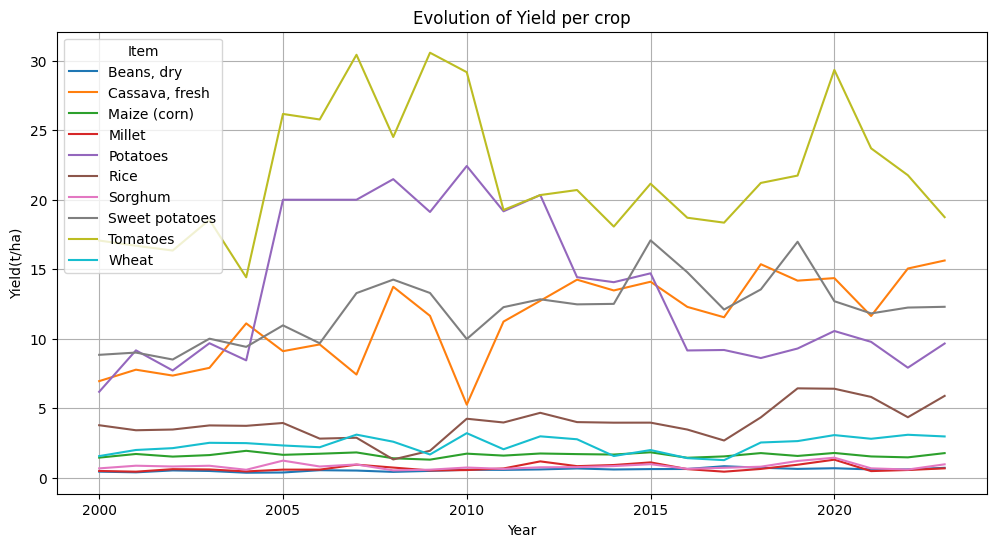

In [59]:
plt.figure(figsize=(12,6))
sns.lineplot(data=clean_data, x="Year", y="Yield(t/ha)", hue="Item")
plt.title("Evolution of Yield per crop")
plt.grid()

plt.savefig("evolution.png", dpi=300)  # Save as high-resolution PNG
plt.show()

In [60]:
unique_crops = clean_data["Item"].unique()

In [61]:
# Create scatter plots for each crop
# fig, axes = plt.subplots(5, 2, figsize=(16, 20))
# axes = axes.flatten()

# for i, crop in enumerate(unique_crops):
#     sub_df = clean_data[clean_data["Item"] == crop]
#     axes[i].scatter(sub_df["temperature(C)"], sub_df["Production(T)"], alpha=0.6, label="Temp vs Prod", color="red")
#     axes[i].set_title(f"{crop}")
#     axes[i].set_xlabel("Climate Variable")
#     axes[i].set_ylabel("Production(T)")
#     axes[i].legend()

# #plt.show();
# plt.tight_layout()
# plt.savefig("data/scatter_plots.png", dpi=300)  # Save as high-resolution PNG



In [62]:
# unique_crops = clean_data["Item"].unique()
# fig, axes = plt.subplots(5, 2, figsize=(16, 20))
# axes = axes.flatten()

# for i, crop in enumerate(unique_crops):
#     sub_df = clean_data[clean_data["Item"] == crop]
#     axes[i].scatter(sub_df["temperature(C)"], sub_df["Production(T)"], alpha=0.6, label="Temp vs Prod", color="red")
#     axes[i].set_title(f"{crop}")
#     axes[i].set_xlabel("Climate Variable")
#     axes[i].set_ylabel("Production(T)")
#     axes[i].legend()
# #plt.show()
# plt.tight_layout()
# plt.savefig("data/scatter_plots.png", dpi=300)  # Save as high-resolution PNG

Beans, dry


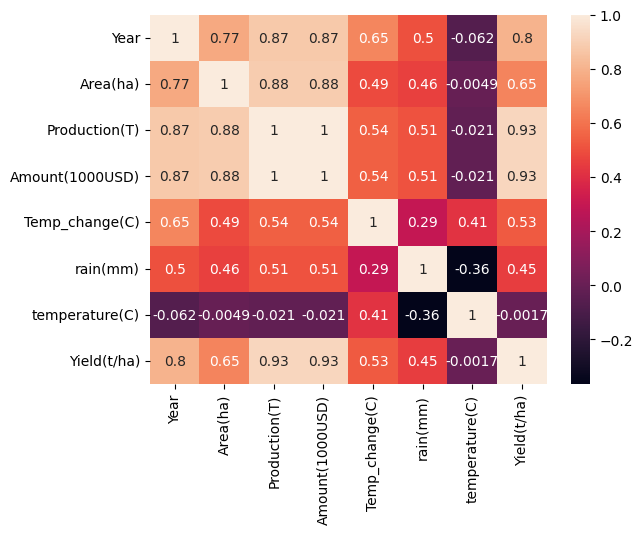

Cassava, fresh


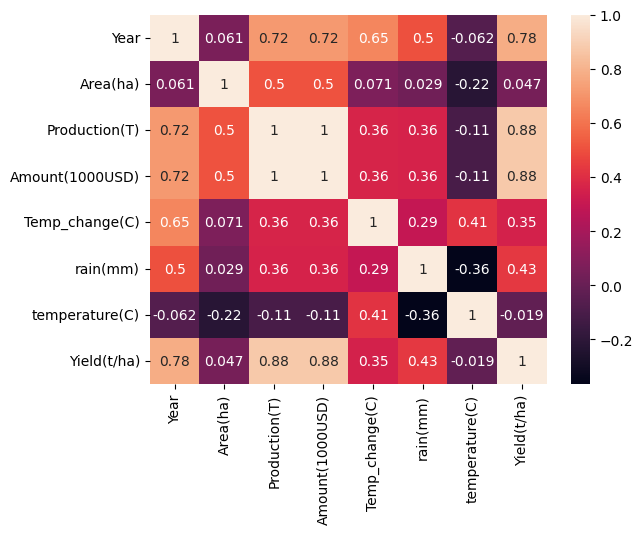

Maize (corn)


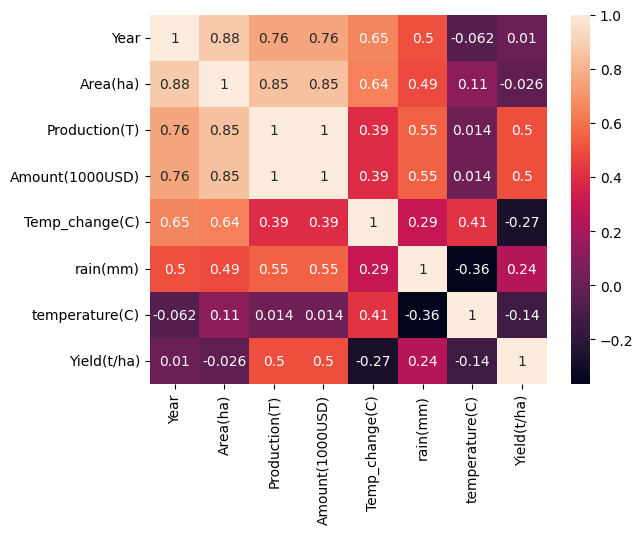

Millet


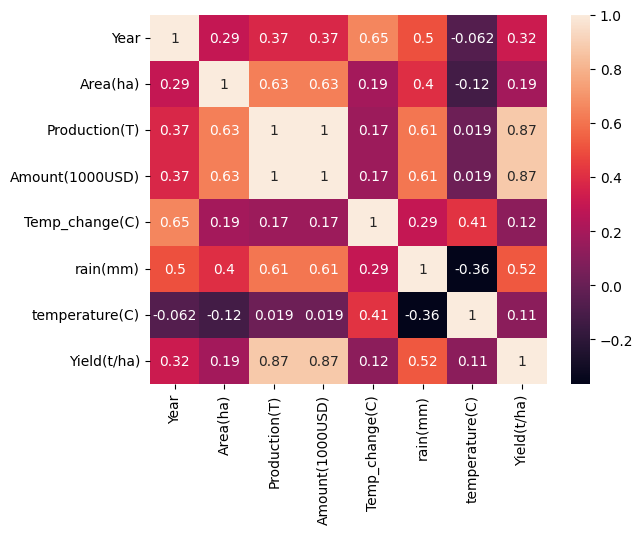

Potatoes


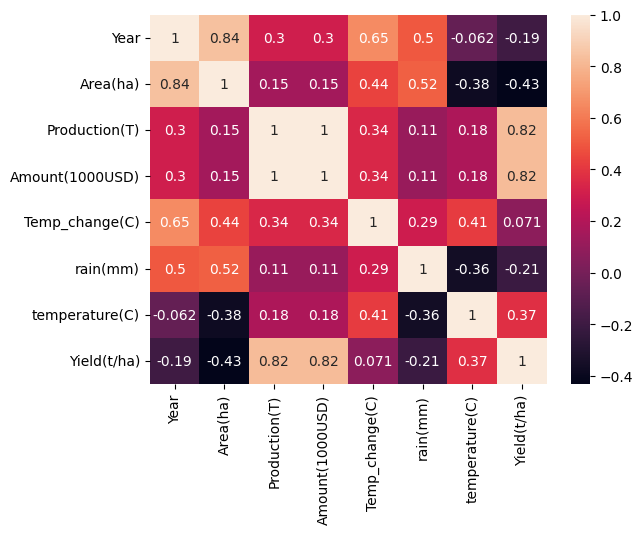

Rice


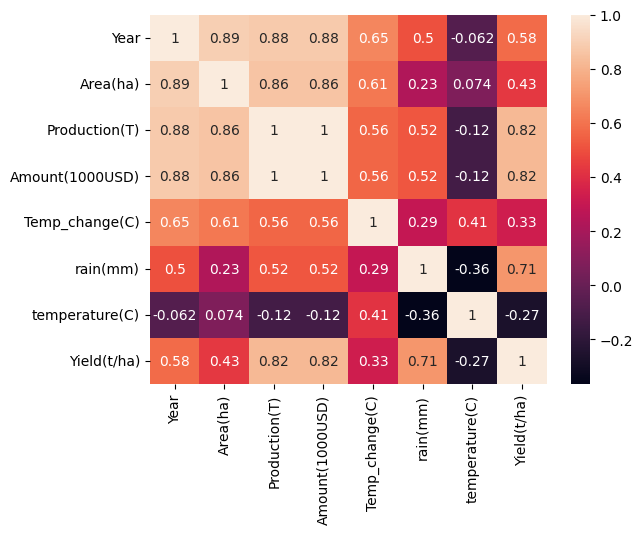

Sorghum


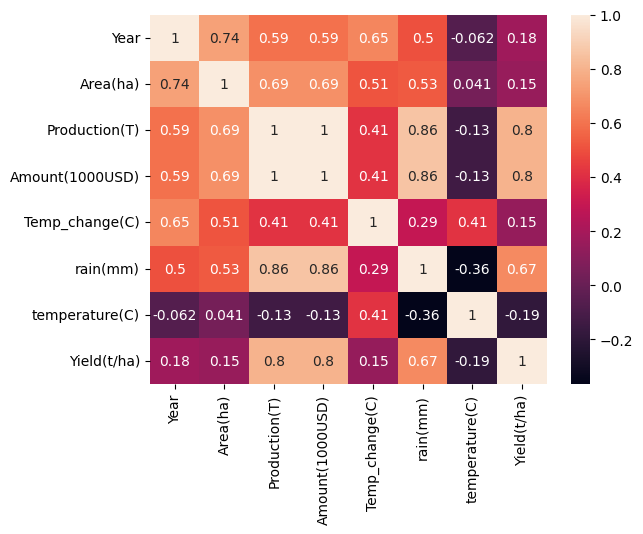

Sweet potatoes


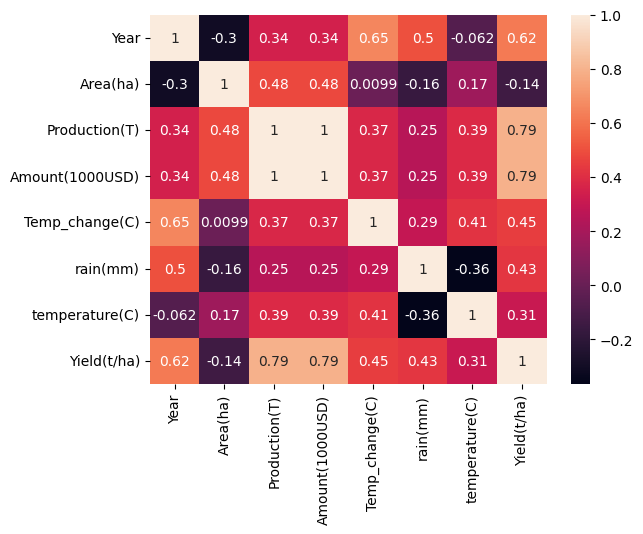

Tomatoes


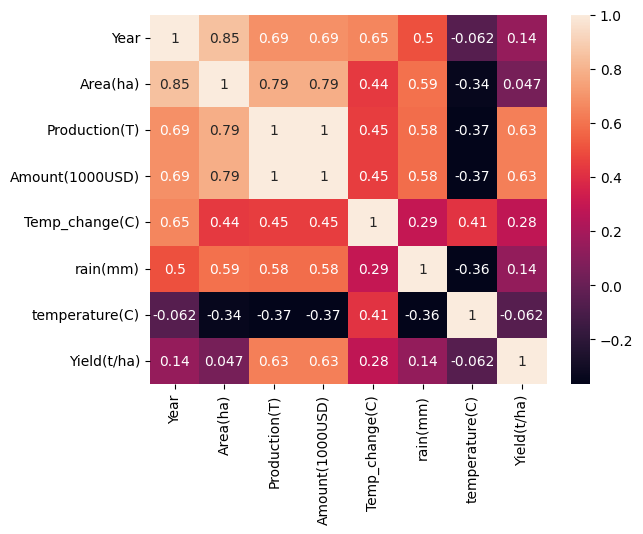

Wheat


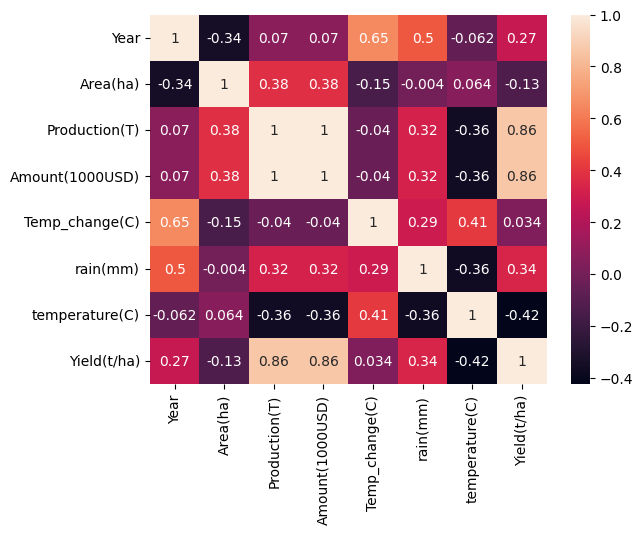

In [72]:
for i, crop in enumerate(unique_crops):
    sub_df = clean_data[clean_data["Item"] == crop]
    
    print(crop)
    
    #Create a correlation matrix for the numerical variabl
    num_variable = sub_df.select_dtypes(include='number')
    
    #Create a correlation matrix
    corr_matrix = num_variable.corr()
    #Make a heatmap out of the corr_matrix
    sns.heatmap(corr_matrix, annot=True)
    plt.savefig(f"data/heat_{crop}.png", dpi=300)  # Save as high-resolution PNG
    plt.show()
    

From the plot we can see that for each crop the rain is highly correlated and we suggest that the rain should be the only input to project the yield of the crop

## 5- Modeling

#### Linear regression with one variable, rain

Beans, dry
[0.53110924 0.5397082  0.55232095 0.55392368 0.56126834]
0    0.429978
1    0.380793
2    0.517732
3    0.478016
4    0.352552
5    0.369565
6    0.534262
7    0.507888
8    0.412823
9    0.484397
Name: Yield(t/ha), dtype: float64
Multivariable R^2 value for Beans, dry: 
 -0.5681035076470262
Yield = 0.032 * Rainfall + 0.553
Cassava, fresh
[11.27164553 11.45386317 11.72113539 11.75509816 11.91073623]
24     6.945415
25     7.768128
26     7.344126
27     7.901464
28    11.100007
29     9.100921
30     9.585603
31     7.418485
32    13.735806
33    11.643124
Name: Yield(t/ha), dtype: float64
Multivariable R^2 value for Cassava, fresh: 
 -2.759984343161916
Yield = 0.681 * Rainfall + 11.740
Maize (corn)
[1.60031528 1.60689534 1.61654681 1.61777323 1.62339348]
48    1.440000
49    1.701220
50    1.512638
51    1.622374
52    1.929318
53    1.640518
54    1.719747
55    1.813153
56    1.392492
57    1.294333
Name: Yield(t/ha), dtype: float64
Multivariable R^2 value for Maize (corn

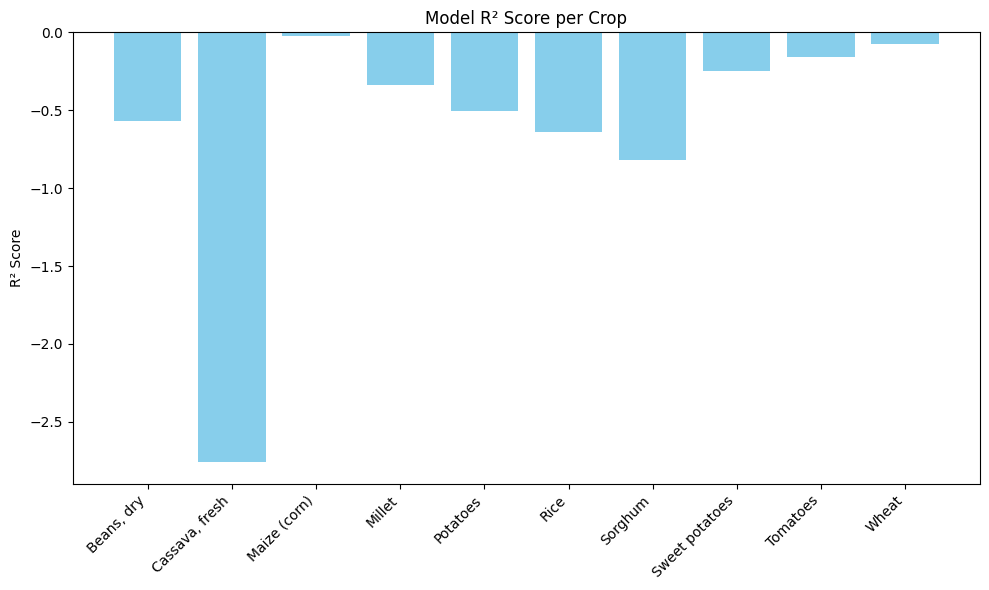

In [67]:

# Create scaler objet
rb_scaler = RobustScaler()

# Create model object
linear_model_multi_variable = LinearRegression()

crop_r2_scores = {}

for i, crop in enumerate(unique_crops):

    print(crop)
    
    #select the corresponding crop data from the clean_data
    crop_data = clean_data[clean_data["Item"] == crop]
    
    #set the target variable as the yield
    y = crop_data["Yield(t/ha)"].to_numpy()

    # We are just going to use numerical data to begin with
    # Drop our count and multicolinear feel_temperature
    numerical_data = crop_data.select_dtypes(include='number')
    
    # removing the irrelevant columns
    numerical_data = numerical_data.drop(columns=["temperature(C)","Yield(t/ha)","Year","Area(ha)","Production(T)","Amount(1000USD)", "Temp_change(C)"])
    #print(numerical_data)

    # Scale the data
    scaled_features = rb_scaler.fit_transform(numerical_data)
    scaled_data = pd.DataFrame(scaled_features, columns = numerical_data.columns)

    # see the scaled_data
    scaled_data.head(3)

    # Using all of the columns from the scaled data.
    X = scaled_data.to_numpy()

    # Split the training and test data.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

    # Fit model
    linear_model_multi_variable.fit(X_train, y_train);

    # Fit model
    linear_model_multi_variable.fit(X_train, y_train);

    # Generate predictions from data.
    y_pred = linear_model_multi_variable.predict(X_test)

    # Show the first 10 predictions
    print(y_pred[:10])
    print(crop_data['Yield(t/ha)'].head(10))

    # Calculate R^2 value using the true and predicted values of y_test.
    r2_value = r2_score(y_test, y_pred)
    crop_r2_scores[crop] = r2_value
    print(f"Multivariable R^2 value for {crop}: \n", r2_value)

    slope = linear_model_multi_variable.coef_[0]
    intercept = linear_model_multi_variable.intercept_
    print(f"Yield = {slope:.3f} * Rainfall + {intercept:.3f}")
 

# Plot
plt.figure(figsize=(10,6))
plt.bar(crop_r2_scores.keys(), crop_r2_scores.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("R² Score")
plt.title("Model R² Score per Crop")
plt.tight_layout()
plt.savefig("r2_scores_per_crop_1.png", dpi=300)
#plt.show()

#### Linear regression with two variable

Beans, dry
[0.52961297 0.54479123 0.54795949 0.5529949  0.55468762]
0    0.429978
1    0.380793
2    0.517732
3    0.478016
4    0.352552
5    0.369565
6    0.534262
7    0.507888
8    0.412823
9    0.484397
Name: Yield(t/ha), dtype: float64
Multivariable R^2 value for Beans, dry: 
 -0.4464386577749755
Cassava, fresh
[11.29369719 11.37895082 11.78541357 11.76878625 12.00772124]
24     6.945415
25     7.768128
26     7.344126
27     7.901464
28    11.100007
29     9.100921
30     9.585603
31     7.418485
32    13.735806
33    11.643124
Name: Yield(t/ha), dtype: float64
Multivariable R^2 value for Cassava, fresh: 
 -2.8606746658605435
Maize (corn)
[1.59899078 1.61139484 1.61268603 1.61695108 1.61756822]
48    1.440000
49    1.701220
50    1.512638
51    1.622374
52    1.929318
53    1.640518
54    1.719747
55    1.813153
56    1.392492
57    1.294333
Name: Yield(t/ha), dtype: float64
Multivariable R^2 value for Maize (corn): 
 -0.047151646118476664
Millet
[0.57559464 0.71154762 0.5810813

ValueError: Format 'png_2' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp)

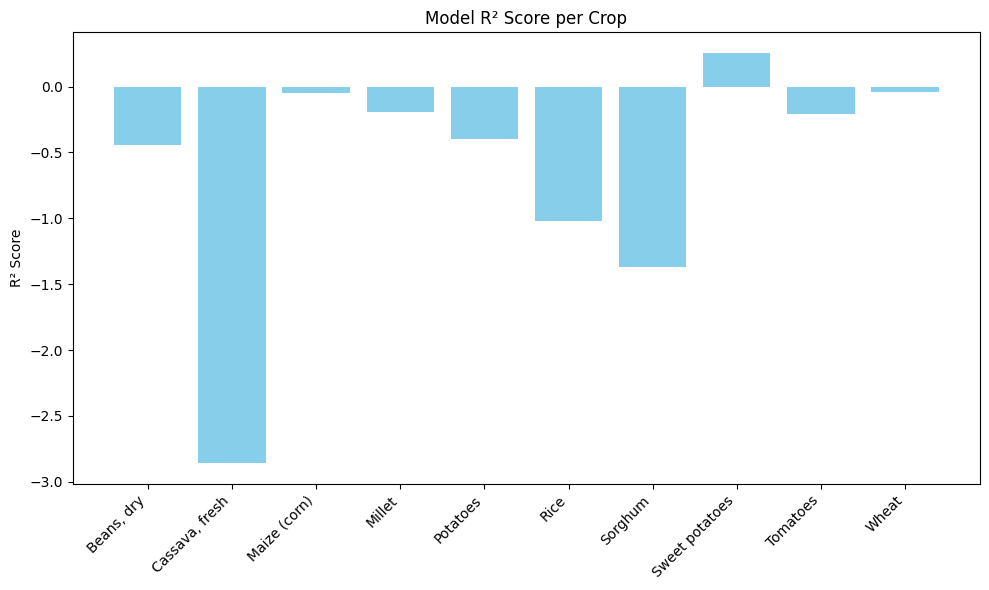

In [68]:

# Create scaler objet
rb_scaler = RobustScaler()

# Create model object
linear_model_multi_variable = LinearRegression()

crop_r2_scores = {}

for i, crop in enumerate(unique_crops):

    print(crop)
    
    #select the corresponding crop data from the clean_data
    crop_data = clean_data[clean_data["Item"] == crop]
    
    #set the target variable as the yield
    y = crop_data["Yield(t/ha)"].to_numpy()

    # We are just going to use numerical data to begin with
    # Drop our count and multicolinear feel_temperature
    numerical_data = crop_data.select_dtypes(include='number')
    
    # removing the irrelevant columns
    numerical_data = numerical_data.drop(columns=["Yield(t/ha)","Year","Area(ha)","Production(T)","Amount(1000USD)", "Temp_change(C)"])
    #print(numerical_data)

    # Scale the data
    scaled_features = rb_scaler.fit_transform(numerical_data)
    scaled_data = pd.DataFrame(scaled_features, columns = numerical_data.columns)

    # see the scaled_data
    scaled_data.head(3)

    # Using all of the columns from the scaled data.
    X = scaled_data.to_numpy()

    # Split the training and test data.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

    # Fit model
    linear_model_multi_variable.fit(X_train, y_train);

    # Fit model
    linear_model_multi_variable.fit(X_train, y_train);

    # Generate predictions from data.
    y_pred = linear_model_multi_variable.predict(X_test)

    # Show the first 10 predictions
    print(y_pred[:10])
    print(crop_data['Yield(t/ha)'].head(10))

    # Calculate R^2 value using the true and predicted values of y_test.
    r2_value = r2_score(y_test, y_pred)
    crop_r2_scores[crop] = r2_value
    print(f"Multivariable R^2 value for {crop}: \n", r2_value)
    
    # # Plot actual vs predicted
    # plt.figure(figsize=(6, 6))
    # sns.scatterplot(x=y_test, y=y_pred, color="green")
    # plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # y = x line
    # plt.xlabel("Actual Yield")
    # plt.ylabel("Predicted Yield")
    # plt.title(f"Actual vs Predicted Yield for {crop}")
    # plt.grid(True)
    # plt.tight_layout()
    # plt.savefig(f"{crop}_pred_vs_actual.png", dpi=300)
    # plt.show()

# Plot
plt.figure(figsize=(10,6))
plt.bar(crop_r2_scores.keys(), crop_r2_scores.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("R² Score")
plt.title("Model R² Score per Crop")
plt.tight_layout()
plt.savefig("r2_scores_per_crop.png", dpi=300)
#plt.show()

       

#### Conclusion

- Most R² values are negative, meaning this model is worse than a horizontal line predicting the mean yield.
- Only Sweet potatoes show some predictive power (R² = 0.25) — still low, but a start.

This suggests that:
- Linear model is too simplistic.
- The relationship between rainfall/temperature and yield is non-linear and possibly crop-specific.
- Other missing features (like soil type, fertilizer use, pest control, or socioeconomic factors) likely play a big role.

#### Try another model: a non linear model (random forest)

Beans, dry
[2.30182942 2.05263247 2.50844678 2.36709568 2.63907324]
0    0.429978
1    0.380793
2    0.517732
3    0.478016
4    0.352552
5    0.369565
6    0.534262
7    0.507888
8    0.412823
9    0.484397
Name: Yield(t/ha), dtype: float64
Random Forest R² for Beans, dry: -5.093085250297785
Cassava, fresh
[2.30182942 2.05263247 2.50844678 2.36709568 2.63907324]
24     6.945415
25     7.768128
26     7.344126
27     7.901464
28    11.100007
29     9.100921
30     9.585603
31     7.418485
32    13.735806
33    11.643124
Name: Yield(t/ha), dtype: float64
Random Forest R² for Cassava, fresh: -1.5350106220618387
Maize (corn)
[2.30182942 2.05263247 2.50844678 2.36709568 2.63907324]
48    1.440000
49    1.701220
50    1.512638
51    1.622374
52    1.929318
53    1.640518
54    1.719747
55    1.813153
56    1.392492
57    1.294333
Name: Yield(t/ha), dtype: float64
Random Forest R² for Maize (corn): 0.636773255752008
Millet
[2.30182942 2.05263247 2.50844678 2.36709568 2.63907324]
72    0.4790

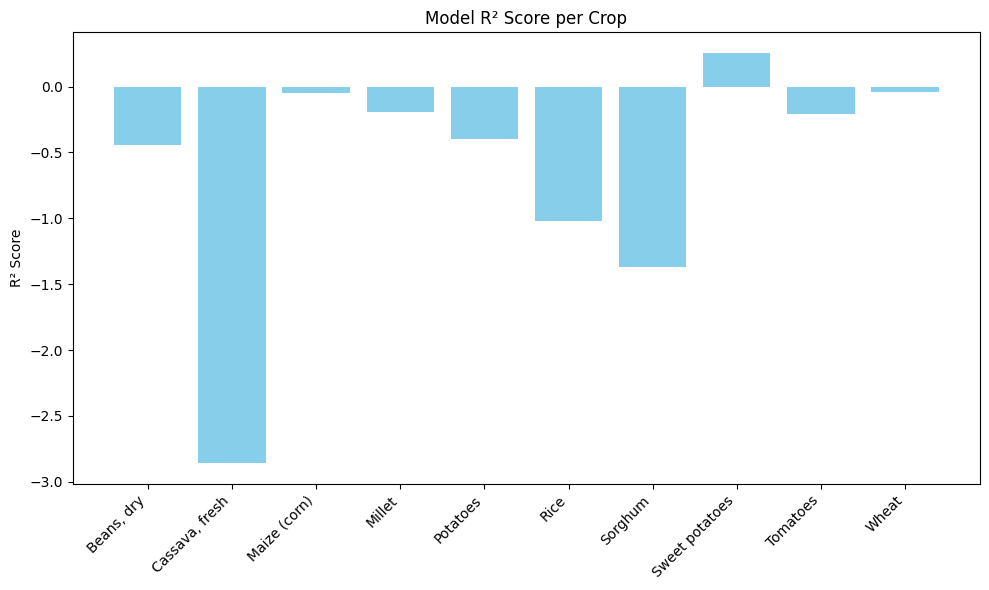

In [69]:
# Create scaler objet
rb_scaler = RobustScaler()


crop_r2_scores_rf = {}

for i, crop in enumerate(unique_crops):

    print(crop)
    
    #select the corresponding crop data from the clean_data
    crop_data = clean_data[clean_data["Item"] == crop]
    
    #set the target variable as the yield
    y = crop_data["Yield(t/ha)"].to_numpy()

    # We are just going to use numerical data to begin with
    # Drop our count and multicolinear feel_temperature
    numerical_data = crop_data.select_dtypes(include='number')
    
    # removing the irrelevant columns
    numerical_data = numerical_data.drop(columns=["Yield(t/ha)","Year","Area(ha)","Production(T)","Amount(1000USD)", "Temp_change(C)"])
    #print(numerical_data)

    # Scale the data
    scaled_features = rb_scaler.fit_transform(numerical_data)
    scaled_data = pd.DataFrame(scaled_features, columns = numerical_data.columns)

    # see the scaled_data
    scaled_data.head(3)

    # Using all of the columns from the scaled data.
    X = scaled_data.to_numpy()

    # Split the training and test data.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

    # Create model object
    rf_model = RandomForestRegressor(random_state=1234)


    # Fit model
    rf_model.fit(X_train, y_train);

    # Generate predictions from data.
    y_pred_rf = rf_model.predict(X_test)

    # Show the first 10 predictions
    print(y_pred[:10])
    print(crop_data['Yield(t/ha)'].head(10))

    # Calculate R^2 value using the true and predicted values of y_test.
    r2_rf = r2_score(y_test, y_pred_rf)
    crop_r2_scores_rf[crop] = r2_value
    print(f"Random Forest R² for {crop}:", r2_rf)

# Plot
plt.figure(figsize=(10,6))
plt.bar(crop_r2_scores.keys(), crop_r2_scores.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("R² Score")
plt.title("Model R² Score per Crop")
plt.tight_layout()
plt.savefig("r2_scores_per_crop_rf.png", dpi=300)
#plt.show()

       

## 6- Prediction

## 7- Conclusion